A Graph Convolutional Network (GCN) layer is defined as:

$$
H^{(l+1)} = \sigma \left( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)} \right)
$$

where:

- $\hat{A} = A + I$ is the adjacency matrix with self-loops  
- $\hat{D}$ is the degree matrix of $\hat{A}$  
- $H^{(l)}$ is the input feature matrix at layer $l$  
- $W^{(l)}$ is the learnable weight matrix at layer $l$  
- $\sigma$ is a non-linear activation function (like ReLU)  

In [38]:
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

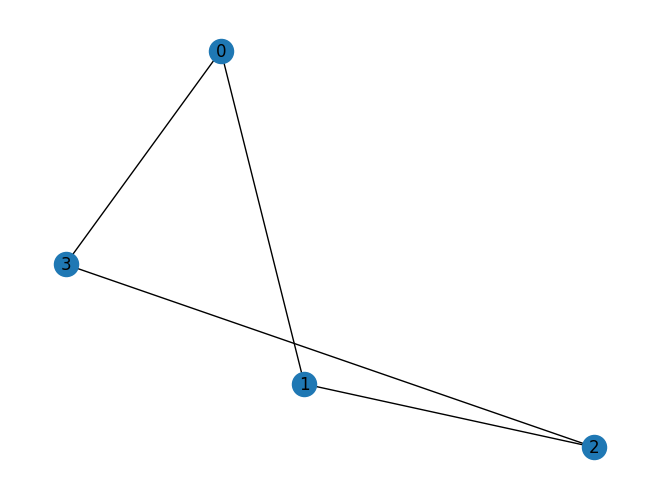

In [33]:
# Let's create a simple graph with only four nodes

G = nx.Graph()
G.add_edges_from([[0,1], [0,3],[1,2], [2,3]])
nx.draw(G, with_labels=True)

In [34]:
# Adjacency matrix 
A = nx.to_numpy_array(G)
print("Adjacency matrix")
print(A)

# add self-loops
A = A + np.identity(A.shape[0])
print("\nAdjacency matrix with self-loops")
print(A)

# Degree matrix
degree_vals = A.sum(axis=1)
D = np.diag(degree_vals)
print("\nDegree matrix")
print(D)

# normalized adjacancy matrix
D_hat = np.linalg.inv(np.sqrt(D))
A_norm = D_hat @ A @ D_hat
print("\nNormalized adjacency matrix")
print(A_norm)

Adjacency matrix
[[0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]

Adjacency matrix with self-loops
[[1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 1.]
 [0. 1. 1. 1.]]

Degree matrix
[[3. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 3.]]

Normalized adjacency matrix
[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.33333333 0.33333333 0.33333333]]


### PyTorch implementation of a 2 layer GCN for node classification task

In [35]:
def get_karateclub():

    G = nx.karate_club_graph()
    X = torch.eye(G.number_of_nodes())

    labels = []
    for i in range(G.number_of_nodes()):
        labels.append(0 if G.nodes[i]["club"] == "Mr. Hi" else 1)

    labels = torch.tensor(labels, dtype=torch.float)
    return G, X, labels

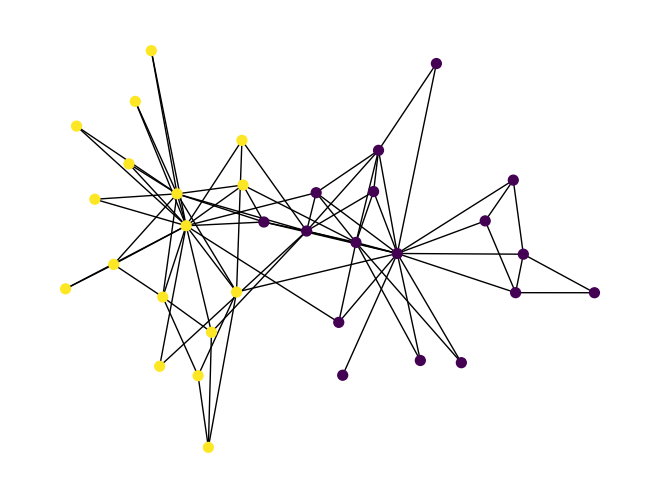

In [45]:
G, X, y = get_karateclub() # G: graph, X: node feature matrix, y: node classes/targets

nx.draw(G, node_size=50, node_color=y)
plt.show()

In [46]:
# determine number of nodes, number of input features, and number of classes
N, f_in, f_out = X.shape[0], X.shape[1], 1 

# compute normalized adjacency matrix
A = nx.to_numpy_array(G, weight=None)
A = A + np.identity(A.shape[0]) 
degree_vals = A.sum(axis=-1) 
D = np.diag(degree_vals)

D_hat = np.linalg.inv(np.sqrt(D))
A_norm = D_hat @ A @ D_hat
A_norm = torch.tensor(A_norm, dtype=torch.float)

In [47]:
f_hidden = 2

W1 = nn.Parameter(torch.randn(f_in, f_hidden))
bias1 = nn.Parameter(torch.zeros(f_hidden))

W2 = nn.Parameter(torch.randn(f_hidden, f_out))
bias2 = nn.Parameter(torch.zeros(f_out))

params = [W1, bias1, W2, bias2]

In [48]:
bce = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([W1, bias1, W2, bias2], lr=0.01)

In [49]:
for e in range(1,101):
    
    optimizer.zero_grad()
    H = torch.relu(A_norm @ X @ W1 + bias1)
    H = A_norm @ H @ W2 + bias2
    loss = bce(H.squeeze(), y)
    loss.backward()
    optimizer.step()

    if e % 10 == 0:
        print(f"Epoch {e}, Loss: {loss.item():.4f}") 

Epoch 10, Loss: 0.7020
Epoch 20, Loss: 0.6803
Epoch 30, Loss: 0.6571
Epoch 40, Loss: 0.6230
Epoch 50, Loss: 0.5787
Epoch 60, Loss: 0.5265
Epoch 70, Loss: 0.4705
Epoch 80, Loss: 0.4146
Epoch 90, Loss: 0.3633
Epoch 100, Loss: 0.3191
